In [1]:
import sys
import torch
from matplotlib import pyplot as plt
import numpy as np

folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

folder_path = '../data/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP

from positional_encoders import *
from plotters import *

In [63]:
batch_size = 1
device = torch.device("cpu")

root_path = '/home/yigit/projects/pemp/outputs/'
test_path = 'comparison/mind_change/freq/bare_pe_promp_gmm/1734968253/'

folder_path = root_path + test_path

y_train = torch.load(folder_path+'y.pt', map_location='cpu').to('cpu')
y_test = torch.load(folder_path+'y_test.pt', map_location='cpu').to('cpu')
x_train = torch.load(folder_path+'x.pt', map_location='cpu').to('cpu')
x_test = torch.load(folder_path+'x_test.pt', map_location='cpu').to('cpu')
g_train = torch.load(folder_path+'g.pt', map_location='cpu').to('cpu')
g_test = torch.load(folder_path+'g_test.pt', map_location='cpu').to('cpu')

num_demos, t_steps, dy = y_train.shape
num_test = y_test.shape[0]
num_trajs = num_demos + num_test
dx, dg, dpe = 1, 1, 27
n_max, m_max = 100, 100
max_freq = torch.max(g_train).item()
min_freq = torch.min(g_train).item()
max_freq = round(max_freq/min_freq)
pe = generate_positional_encoding(t_steps, dpe)

Y = torch.cat([y_train, y_test], dim=0).numpy().squeeze(-1)
x = torch.cat([x_train, x_test], dim=0).numpy().squeeze(-1)

/tmp/ipykernel_24362/3304669088.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_train = torch.load(folder_path+'y.pt', map_location='cpu').to('cpu')
/tmp/ipykernel_243

In [3]:
models_folder = folder_path + 'saved_models/'
bare_path = models_folder + 'bare.pt'
pemp_path = models_folder + 'pe.pt'

enc_dims = [256,256]
dec_dims = [256,256]

bare = CNMP(input_dim=dx+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)
pemp = CNMP(input_dim=dpe+dg, output_dim=dy, n_max=n_max, m_max=m_max, encoder_hidden_dims=enc_dims, decoder_hidden_dims=dec_dims, batch_size=batch_size, device=device)

bare.load_state_dict(torch.load(bare_path, map_location=device))
pemp.load_state_dict(torch.load(pemp_path, map_location=device))

/tmp/ipykernel_24362/278280830.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bare.load_state_dict(torch.load(bare_path, map_location=device))
/tmp/ipykernel_24362/278

<All keys matched successfully>

In [187]:
# Plotting parameters
colors = ['#377eb8', '#e41a1c', '#ff7f00', '#f781bf', '#4daf4a', '#a65628', '#984ea3', '#999999', '#dede00']
linestyles = [(0, (3, 1, 1, 1, 1, 1)), (0, (1, 1)), '--', (0, (5, 10)), ':', '-.', '-', (0, (1, 3))]

promp_index = 0
bare_index = 1
pemp_index = 2

labels = ['ProMP', 'CNMP', 'PEMP']
num_models = len(labels)

In [5]:
bare_obs = torch.zeros((batch_size, n_max, dx+dg+dy), dtype=torch.float32, device=device)
bare_tar_x = torch.zeros((batch_size, t_steps, dx+dg), dtype=torch.float32, device=device)

pemp_obs = torch.zeros((batch_size, n_max, dpe+dg+dy), dtype=torch.float32, device=device)
pemp_tar_x = torch.zeros((batch_size, t_steps, dpe+dg), dtype=torch.float32, device=device)

obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

n = np.random.randint(0, n_max)

bare_obs.fill_(0)
bare_tar_x.fill_(0)
pemp_obs.fill_(0)
pemp_tar_x.fill_(0)
obs_mask.fill_(False)

obs_mask[0, :n] = True

bare_tar_x[0, :, :dx] = torch.linspace(0, 1, t_steps).unsqueeze(1)
pemp_tar_x[0, :, :dpe] = pe

In [6]:
# Training Contextual ProMPs

from gmr import GMM
from movement_primitives.promp import ProMP

num_promps = 30
n_weights_per_dim = 30

Ts = np.array([np.linspace(0, 1, t_steps) for _ in range(num_demos)])  # Shape: (num_demos, t_steps)
Ys = y_train.numpy()  # Shape: (num_demos, t_steps, dy)

promps = []
for i in range(num_promps - 2):
    promps.append(ProMP(n_dims=dy, n_weights_per_dim=i + 8))  # Vary weights
promps.append(ProMP(n_dims=dy, n_weights_per_dim=40))  # Fixed higher number
promps.append(ProMP(n_dims=dy, n_weights_per_dim=50))  # Fixed higher number

# Train each ProMP and collect weights
gmm_list = []  # To store GMM models for each ProMP
for promp in promps:
    print(f"     Training ProMP with {promp.n_weights_per_dim} weights     ")
    promp.imitate(Ts, Ys, n_iter=1000, min_delta=1e-6, verbose=1)  # Train ProMP

    # Extract weights from the ProMP
    n_weights_per_dim = promp.n_weights_per_dim
    weights = np.empty((num_demos, dy * n_weights_per_dim))
    for i in range(num_demos):
        weights[i] = promp.weights(Ts[i], Ys[i])

    # Train GMM with context (frequencies) and weights
    X = np.hstack((g_train, weights))  # Combine frequency (context) with weights
    gmm = GMM(n_components=5, random_state=42)
    gmm.from_samples(X)
    gmm_list.append(gmm)  # Store GMM for this ProMP

     Training ProMP with 8 weights     
Iteration 0001: delta = 0.106716
Iteration 0002: delta = 0.0298497
Iteration 0003: delta = 5.71171e-08
     Training ProMP with 9 weights     
Iteration 0001: delta = 0.148273
Iteration 0002: delta = 0.0619381
Iteration 0003: delta = 9.16198e-08
     Training ProMP with 10 weights     
Iteration 0001: delta = 0.157461
Iteration 0002: delta = 0.066718
Iteration 0003: delta = 8.53964e-08
     Training ProMP with 11 weights     
Iteration 0001: delta = 0.153481
Iteration 0002: delta = 0.0583166
Iteration 0003: delta = 5.62375e-08
     Training ProMP with 12 weights     
Iteration 0001: delta = 0.175285
Iteration 0002: delta = 0.0920052
Iteration 0003: delta = 1.47286e-07
     Training ProMP with 13 weights     
Iteration 0001: delta = 0.178004
Iteration 0002: delta = 0.0927655
Iteration 0003: delta = 1.46357e-07
     Training ProMP with 14 weights     
Iteration 0001: delta = 0.179295
Iteration 0002: delta = 0.0881534
Iteration 0003: delta = 1.36474

In [170]:
test_traj_ind = np.random.randint(0, num_test)
test_x_inds = np.random.randint(0, t_steps, n)
test_ys = y_test[test_traj_ind, test_x_inds] + torch.from_numpy(np.random.normal(0, 0.01, (n, dy)))
test_g = g_test[test_traj_ind].item()

In [171]:
# ProMP trajectories
promp_trajs = []
for idx, (promp, gmm) in enumerate(zip(promps, gmm_list)):
    freq_query = np.array([[test_g]])  # Example frequency query
    conditional_weight_distribution = gmm.condition(np.arange(1), freq_query).to_mvn()

    # Update the trained ProMP's weight distribution
    promp.from_weight_distribution(
        conditional_weight_distribution.mean,
        conditional_weight_distribution.covariance
    )

    # Add conditions and generate trajectories
    for i in range(n):
        test_x_ind = test_x_inds[i]
        test_y = test_ys[i]
        cond_point = np.array([test_y])
        t = x_test[test_traj_ind, test_x_ind].item()
        promp.condition_position(cond_point, t=t)

    # Generate trajectory directly from the trained ProMP
    promp_trajectory = promp.sample_trajectories(x[0], 1, np.random.RandomState(seed=1234))[0]
    promp_trajs.append(promp_trajectory)

In [172]:
promp_dists = np.zeros(num_promps)
for idx, promp_traj in enumerate(promp_trajs):
    dist = np.linalg.norm(promp_traj - y_test[test_traj_ind].numpy())
    promp_dists[idx] = dist
    # print(f'ProMP {idx} distance: {dist}')

In [173]:
for i in range(n):
    test_x_ind = test_x_inds[i]
    test_y = test_ys[i]
    bare_obs[0, i, :dx] = x_test[test_traj_ind, test_x_ind]
    bare_obs[0, i, dx:dx+dg] = test_g #g_test[test_x_ind]
    bare_obs[0, i, dx+dg:] = test_y

    pemp_obs[0, i, :dpe] = pe[test_x_ind]
    pemp_obs[0, i, dpe:dpe+dg] = test_g #g_test[test_x_ind]
    pemp_obs[0, i, dpe+dg:] = test_y
bare_tar_x[0, :, dx:] = test_g
pemp_tar_x[0, :, dpe:] = test_g

bare_trajectory = bare.val(bare_obs, bare_tar_x, obs_mask)[:, :, :dy]
pemp_trajectory = pemp.val(pemp_obs, pemp_tar_x, obs_mask)[:, :, :dy]

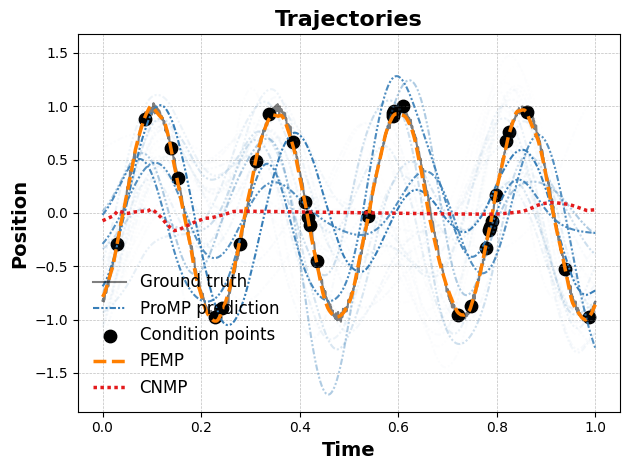

In [ ]:
plt.plot(x_test[0], y_test[test_traj_ind].cpu().numpy(), color='black', label='Ground truth', alpha=0.5)
min_dist_ind = np.argmin(promp_dists)
for i in range(num_promps):
    plt.plot(x_test[0], promp_trajs[i], color=colors[promp_index], linestyle=linestyles[promp_index], alpha=(np.min(promp_dists)/promp_dists[i])**10, label='ProMP prediction' if i==min_dist_ind else '')

for i in range(n):
    test_x_ind = test_x_inds[i]
    test_y = test_ys[i]
    cond_point = np.array([test_y])
    t = x_test[test_traj_ind, test_x_ind].item()*t_steps
    plt.scatter(t/t_steps, cond_point, color='black', s=80, label='Condition points' if i==0 else '')

plt.title("Trajectories", fontsize=16, fontweight='bold')
plt.xlabel("Time", fontsize=14, fontweight='bold')
plt.ylabel("Position", fontsize=14, fontweight='bold')
plt.ylim = (-1.0, 1.0)
plt.plot(x_test[0], pemp_trajectory[0].cpu().detach().numpy(), color=colors[pemp_index], linestyle=linestyles[pemp_index], linewidth=2.5, label='PEMP')
plt.plot(x_test[0], bare_trajectory[0].cpu().detach().numpy(), color=colors[bare_index], linestyle=linestyles[bare_index], linewidth=2.5, label='CNMP')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(loc='best', frameon=True, framealpha=0.5, fontsize=12)
plt.tight_layout()
plt.show()

In [175]:
# for i in range(0, num_demos, 1):
#     color_ind = round(g_train[i].item()*max_freq)
#     if color_ind == 5:
#         plt.plot(x_train[i], y_train[i].cpu().numpy(), color=colors[color_ind], alpha=0.25)
#     # plt.plot(x_test[0], y_train[i].cpu().numpy(), color='#d4d4d4', alpha=0.5)
# plt.xlabel('Time')
# plt.ylabel('Position')
# plt.title('Demonstration Trajectories')
# plt.grid()
# # plt.legend()
# plt.show()

In [176]:
# for i in range(n):
#     test_x_ind = test_x_inds[i]
#     test_y = test_ys[i]
#     cond_point = np.array([test_y])
#     t = x_test[test_traj_ind, test_x_ind].item()*t_steps
#     plt.scatter(t/t_steps, cond_point, color='black', s=40, label='Condition points' if i==0 else '')
# plt.plot(x_test[0],y_test[test_traj_ind].cpu().numpy(), color='black', label='Ground truth')
# min_dist_ind = np.argmin(promp_dists)
# for i in range(num_promps):
#     plt.plot(x_test[0], promp_trajs[i], color=colors[promp_index], linestyle=linestyles[promp_index], alpha=(np.min(promp_dists)/promp_dists[i])**6, label='ProMP prediction' if i==min_dist_ind else '')

# plt.grid()
# plt.legend(loc='upper right')


In [188]:
from tqdm import tqdm

num_comparisons = 1000
comp_dists = np.zeros((num_comparisons, num_models))


for comp_ind in tqdm(range(num_comparisons)):
    n = np.random.randint(0, n_max)
    test_traj_ind = np.random.randint(0, num_test)
    test_x_inds = np.random.randint(0, t_steps, n)
    test_ys = y_test[test_traj_ind, test_x_inds] + torch.from_numpy(np.random.normal(0, 0.01, (n, dy)))
    test_g = g_test[test_traj_ind].item()

    for i in range(n):
        test_x_ind = test_x_inds[i]
        test_y = test_ys[i]
        bare_obs[0, i, :dx] = x_test[test_traj_ind, test_x_ind]
        bare_obs[0, i, dx:dx+dg] = test_g #g_test[test_x_ind]
        bare_obs[0, i, dx+dg:] = test_y

        pemp_obs[0, i, :dpe] = pe[test_x_ind]
        pemp_obs[0, i, dpe:dpe+dg] = test_g #g_test[test_x_ind]
        pemp_obs[0, i, dpe+dg:] = test_y
    bare_tar_x[0, :, dx:] = test_g
    pemp_tar_x[0, :, dpe:] = test_g

    bare_trajectory = bare.val(bare_obs, bare_tar_x, obs_mask)[:, :, :dy]
    pemp_trajectory = pemp.val(pemp_obs, pemp_tar_x, obs_mask)[:, :, :dy]


    promp_trajs = []
    for idx, (promp, gmm) in enumerate(zip(promps, gmm_list)):
        freq_query = np.array([[test_g]])  # Example frequency query
        conditional_weight_distribution = gmm.condition(np.arange(1), freq_query).to_mvn()

        # Update the trained ProMP's weight distribution
        promp.from_weight_distribution(
            conditional_weight_distribution.mean,
            conditional_weight_distribution.covariance
        )

        # Add conditions and generate trajectories
        for i in range(n):
            test_x_ind = test_x_inds[i]
            test_y = test_ys[i]
            cond_point = np.array([test_y])
            t = x_test[test_traj_ind, test_x_ind].item()
            promp.condition_position(cond_point, t=t)

        # Generate trajectory directly from the trained ProMP
        promp_trajectory = promp.sample_trajectories(x[0], 1, np.random.RandomState(seed=1234))[0]
        promp_trajs.append(promp_trajectory)

    promp_dists = np.zeros(num_promps)
    for idx, promp_traj in enumerate(promp_trajs):
        dist = np.linalg.norm(promp_traj - y_test[test_traj_ind].numpy())
        promp_dists[idx] = dist

    bare_dist = np.linalg.norm(bare_trajectory[0].cpu().detach().numpy() - y_test[test_traj_ind].numpy())
    pemp_dist = np.linalg.norm(pemp_trajectory[0].cpu().detach().numpy() - y_test[test_traj_ind].numpy())
    promp_dist = np.min(promp_dists)
    comp_dists[comp_ind, promp_index] = promp_dist
    comp_dists[comp_ind, pemp_index] = pemp_dist
    comp_dists[comp_ind, bare_index] = bare_dist

100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


In [189]:
dist_means = comp_dists.mean(axis=0)
dist_stds = comp_dists.std(axis=0)

print(f'Means: ProMP: {dist_means[promp_index]}, CNMP: {dist_means[bare_index]}, PEMP: {dist_means[pemp_index]}')
print(f'Stds: ProMP: {dist_stds[promp_index]}, CNMP: {dist_stds[bare_index]}, PEMP: {dist_stds[pemp_index]}')
# plt.hist(comp_dists[:, promp_index], bins=50, alpha=0.5, color=colors[promp_index], label='ProMP')

Means: ProMP: 17.269668271297167, CNMP: 17.287777954161168, PEMP: 5.877199876368046
Stds: ProMP: 4.938563415578809, CNMP: 8.591594619381931, PEMP: 8.969470073353648


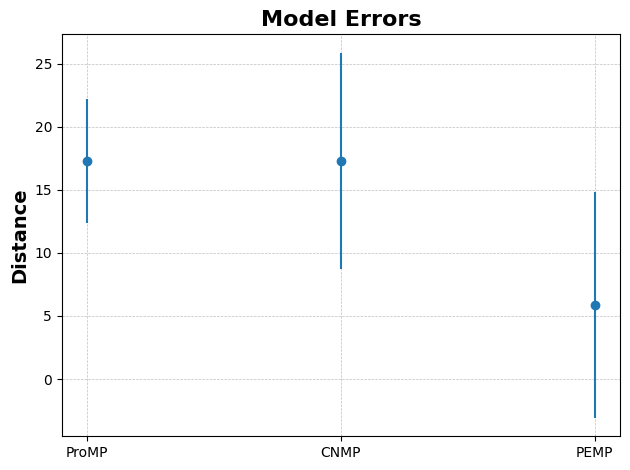

In [190]:
# plot mean errors and standard deviations 
x_labels = ['ProMP', 'CNMP', 'PEMP']
plt.errorbar(x_labels, dist_means, dist_stds, fmt='o')
plt.title("Model Errors", fontsize=16, fontweight='bold')
plt.ylabel("Distance", fontsize=14, fontweight='bold')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()